# The super-cheap SDR project: Receiving

Tim Molteno (ZL4TCM)

Some basic models of the components of the super-cheap SDR. The goal, why do it well when we can do it cheaply...

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import scipy

## The Signal

We'll assume that we're operating in the 6 meter band, so the signal will be a 50 MHz signal modulated using FM, carrying a voice signal that is someone whistling at 10kHz. The signal bandwidth=20kHz

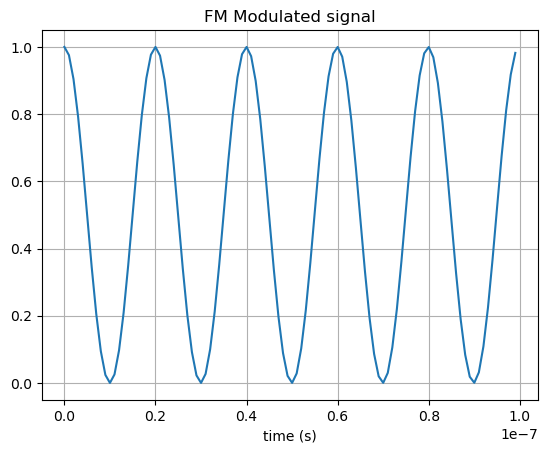

In [2]:
f_sig = 50e6
n_periods = 50000
t_max = n_periods*(1/f_sig)
fs = f_sig*20
t = np.linspace(0, t_max, int(t_max*fs))
omega_f = 2*np.pi*f_sig


## FM modulation
f_voice = 10e3  # 10 kHz
A_m = 1         # Amplitude of voice
omega_voice = 2*np.pi*f_voice
voice = A_m * np.cos(omega_voice*t)

f_delta = 75e3 # 100 kHz spacing (exagerating) K_f * A_m

signal = np.cos(omega_f*t + (f_delta / f_voice)*np.sin(omega_voice*t))
signal = (signal + 1 )/ 2

n = 100
plt.plot(t[0:n], signal[0:n]);
plt.xlabel('time (s)')
plt.title('FM Modulated signal')
plt.grid(True)

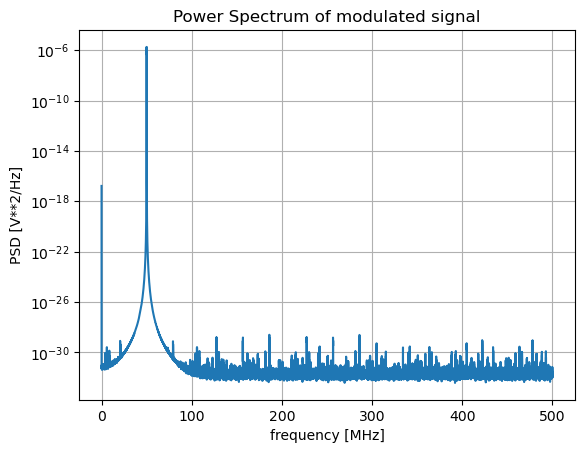

In [3]:
f, Pxx_den = scipy.signal.welch(signal, fs, nperseg=len(signal)/10)

plt.semilogy(f/1e6, Pxx_den);
plt.xlabel('frequency [MHz]');
plt.ylabel('PSD [V**2/Hz]');
plt.title('Power Spectrum of modulated signal')
plt.grid()

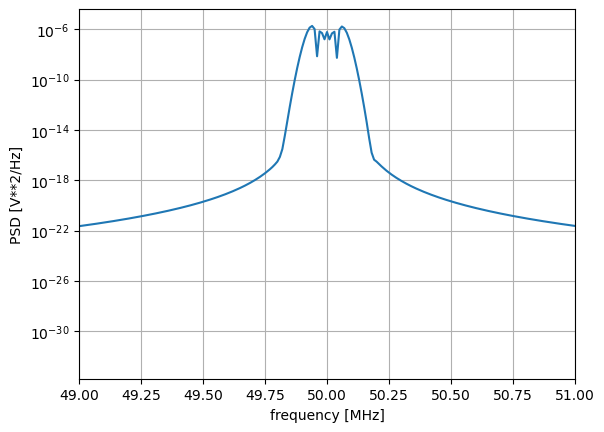

In [4]:
plt.semilogy(f/1e6, Pxx_den);
plt.xlabel('frequency [MHz]');
plt.ylabel('PSD [V**2/Hz]');
plt.xlim([49, 51])
plt.grid()

## The Local Oscillator

This is a frequency synthesizer (MS5351 | https://www.relmon.com/en/index.php/welcome/download/347.html) that can produce a frequency (I and Q) between 2.5 kHz and 200 MHz.

The output is a square wave at logic 3.3V levels. Controlled by I2C.

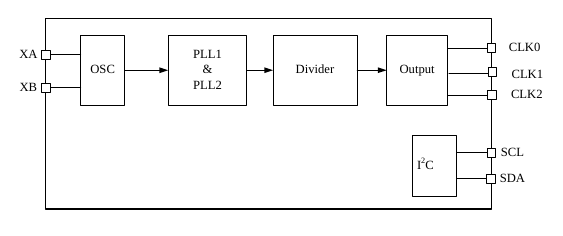

The output is a square wave at the desired frequency, $f_{LO}$. 

We will use direct to baseband complex mixer where the local oscillator is set to be at the center frequency of the signal.

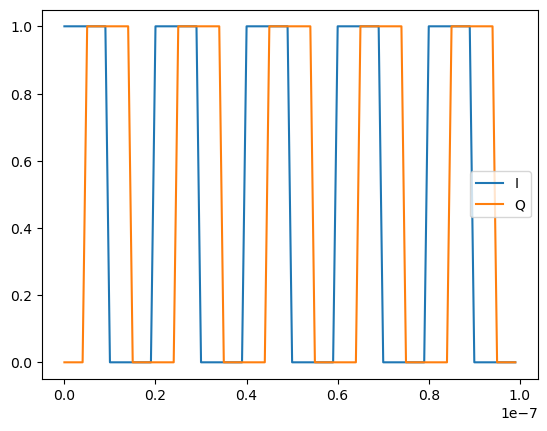

In [5]:
f_LO = f_sig
lo_i = (scipy.signal.square(2*np.pi*f_LO*t, duty=0.5) + 1) / 2
lo_q = (scipy.signal.square(2*np.pi*f_LO*t - np.pi/2, duty=0.5) + 1) / 2

n = 100
plt.plot(t[0:n], lo_i[0:n], label='I');
plt.plot(t[0:n], lo_q[0:n], label='Q');
plt.legend();

## The mixer

How should this be done. We can use an analogue multiplier, or a switching mixer. We'll try switching. This means that the LO controls a switch (when the LO is HI, the signal gets through, when the LO is LOW, the result is zero)

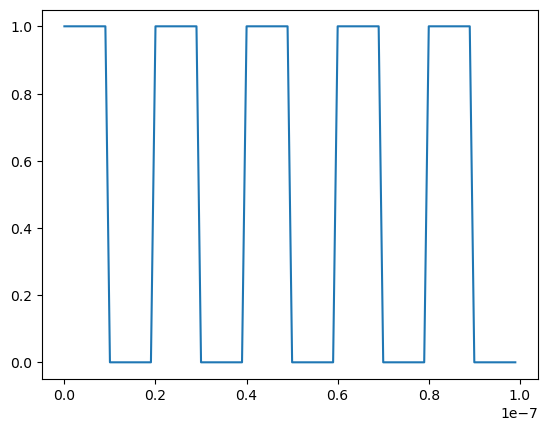

In [6]:
switch_i = lo_i > 0
switch_q = lo_q > 0

plt.plot(t[0:n], switch_i[0:n]);

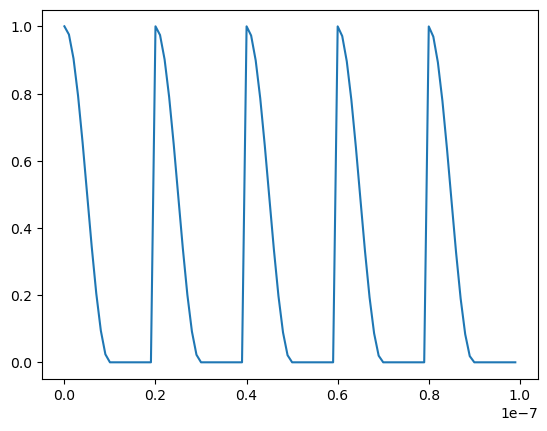

In [7]:
i_out = signal*switch_i  # The I channel of the mixer
q_out = signal*switch_q  # The Q channel of the mixer

plt.plot(t[0:n], i_out[0:n]);

So what does this 'mixed' signal look like. Here is the spectrum...

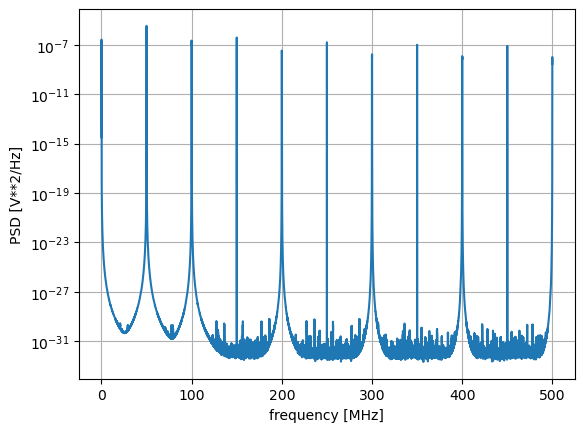

In [8]:
f, Pxx_den = scipy.signal.welch(i_out, fs, nperseg=len(signal)/10)

plt.semilogy(f/1e6, Pxx_den);
plt.xlabel('frequency [MHz]');
plt.ylabel('PSD [V**2/Hz]');
plt.grid()

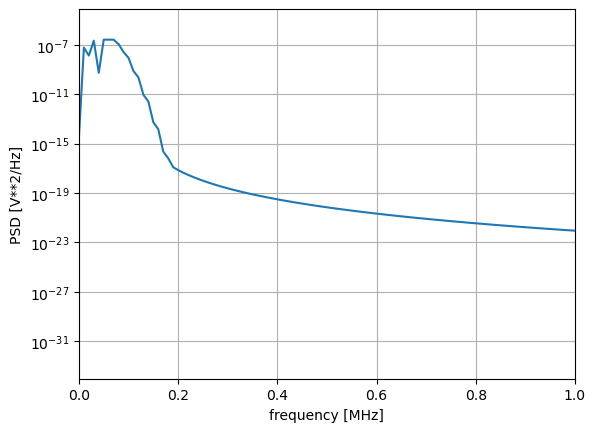

In [9]:
plt.semilogy(f/1e6, Pxx_den);
plt.xlabel('frequency [MHz]');
plt.ylabel('PSD [V**2/Hz]');
plt.xlim([0, 1])
plt.grid()

## Complex mixing

So there is a trick. We can form a complex signal and recover the negative part of the spectrum at zero-frequency :)

/usr/lib/python3/dist-packages/scipy/signal/_spectral_py.py:1867: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


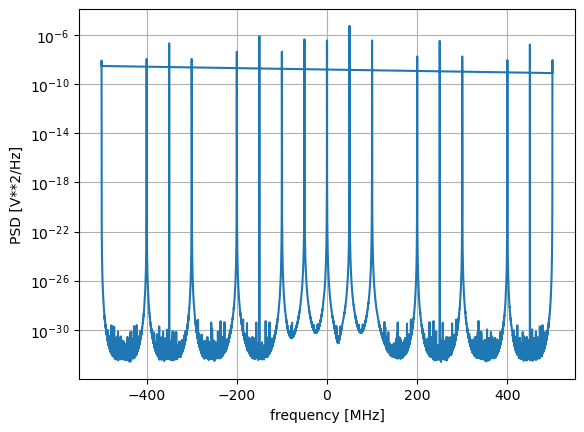

In [10]:
bb = i_out + 1.0j*q_out

f, Pxx_den = scipy.signal.welch(bb, fs, nperseg=len(signal)/10, return_onesided=True)

plt.semilogy(f/1e6, Pxx_den);
plt.xlabel('frequency [MHz]');
plt.ylabel('PSD [V**2/Hz]');
plt.grid()

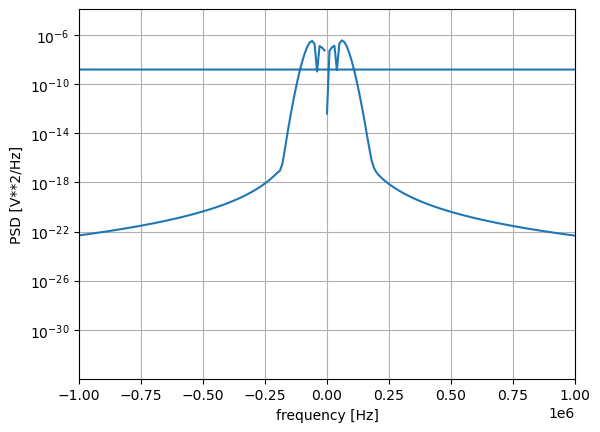

In [11]:
plt.semilogy(f, Pxx_den);
plt.xlabel('frequency [Hz]');
plt.ylabel('PSD [V**2/Hz]');
plt.xlim([-1e6, 1e6])
plt.grid()


So the mixer works. Recovering the modulated spectrum right down at zero frequency. This means we don't need a really fast ADC to recover the original signal! We just need to low-pass filter the 


## Low pass filtering

After mixing, we need a low pass filter. We can do this with something simple, like an RC filter, and filter these. Let's filter with a cutoff at 500 kHz. 

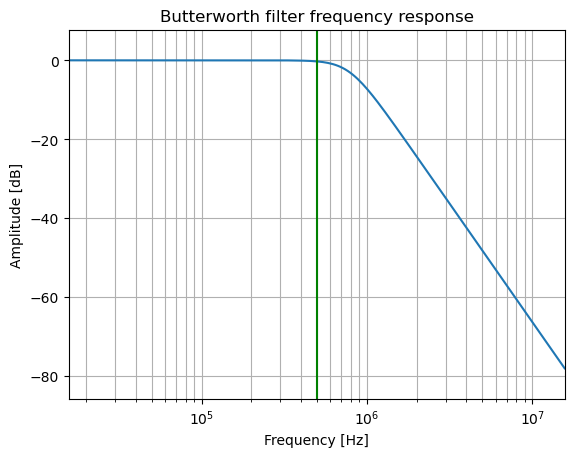

In [12]:
f_co = 500e3
b, a = scipy.signal.butter(3, f_co, 'low', analog=True)

w, h = scipy.signal.freqs(b, a)
plt.semilogx(w/2*np.pi, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(f_co, color='green') # cutoff frequency

plt.show()

In [13]:
sos = scipy.signal.butter(3, f_co, 'low', fs=fs, output='sos')

i_lpf = scipy.signal.sosfilt(sos, i_out)
q_lpf = scipy.signal.sosfilt(sos, q_out)

bb_lpf = i_lpf - 1.0j*q_lpf

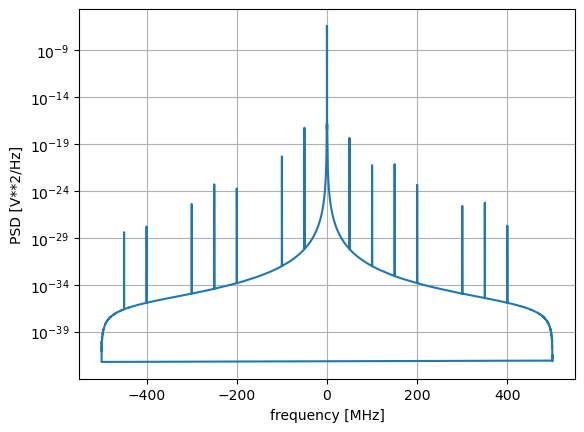

In [14]:
f, Pxx_den = scipy.signal.welch(bb_lpf, fs, nperseg=len(signal)/10)

plt.semilogy(f/1e6, Pxx_den);
plt.xlabel('frequency [MHz]');
plt.ylabel('PSD [V**2/Hz]');
plt.grid()

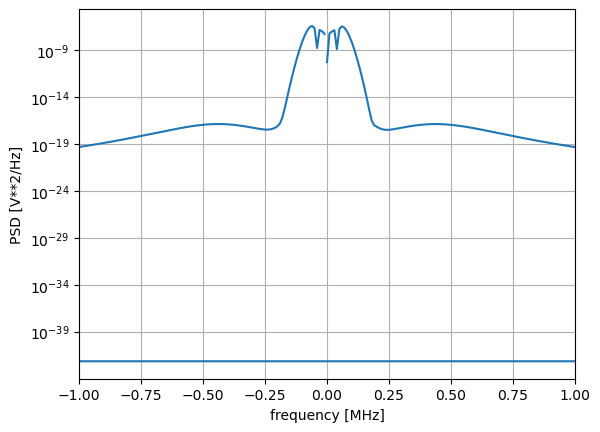

In [15]:
plt.semilogy(f/1e6, Pxx_den);
plt.xlabel('frequency [MHz]');
plt.ylabel('PSD [V**2/Hz]');
plt.xlim([-1, 1])
plt.grid()

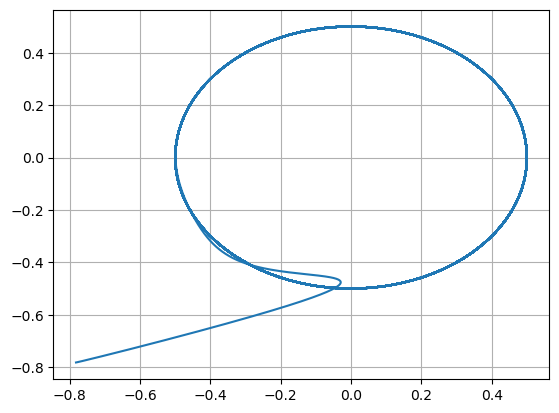

In [16]:
# Remove i/q DC offsets (can be done digitally)
n = 100000
i = (i_lpf - np.min(i_lpf[n:]))/(np.max(i_lpf[n:]) - np.min(i_lpf[n:])) - 0.5
q = (q_lpf - np.min(q_lpf[n:]))/(np.max(q_lpf[n:]) - np.min(q_lpf[n:])) - 0.5
plt.grid(True)
plt.plot(i, q);

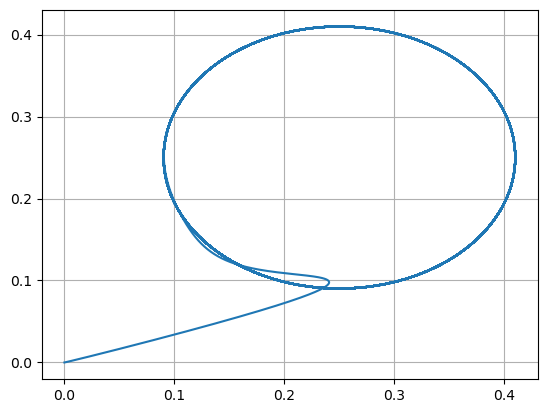

In [17]:
plt.plot(i_lpf, q_lpf);
plt.grid(True)

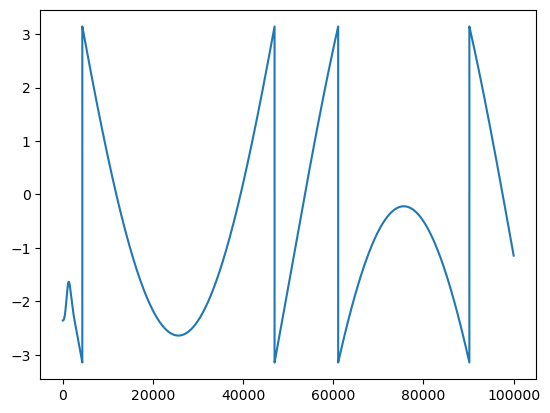

In [18]:
## Demod
bb = i + 1.0j*q
phase = np.angle(bb)
plt.plot(phase[0:100000])

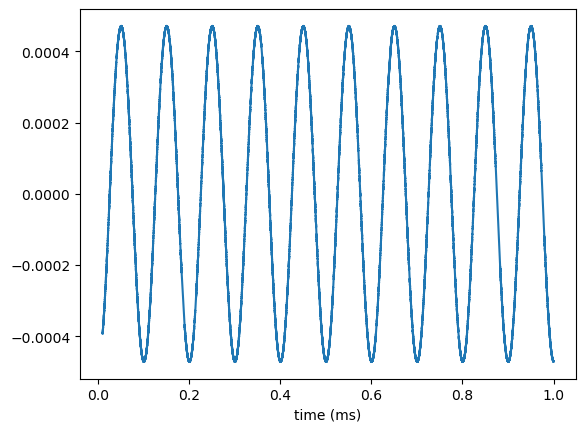

In [19]:
demod = np.unwrap(phase[1:-1] - phase[0:-2])
dt = t[0:-2]
plt.plot(dt[10000:-1]*1000, demod[10000:-1]);
plt.xlabel('time (ms)');

so we can demodulate FM pretty well by doing a little math (arctan2)...

## What about modulation errors

What happens if the mixer switch isn't perfect (is not symmetric e.t.c.)...

* Asymmetry in the low-pass filters
* Slew-rate limitations in the switches
* Asymmetry in the switches (switching on faster than off)...
* Phase difference between I and Q not being 90 degrees.
* Quantization. Our DAC is crappy, and we'll use some kind of AGC...
* Nonlinearity. Luckily cheap CPU's have perfect DACs :)

These are left as an exercise for the audience...

### Thoughts

When reconstructing the complex waveform
$$ z = i_{out} + j q_{out} $$
We could undo some of the imperfections (if they're known, or can be measured)
$$ z = \alpha_i i_{out} + \alpha_j e^{j \phi} q_{out} $$
where $\alpha_i$ and $\alpha_j$ are scaling factors, and $\phi$ is a phase factor... 

## Real switches

The SN74LVC1G66 require input voltages between 0 and 3.3 V. 

This is no problem for the LO output which is logic level, but something will need to be done for the RF input after amplification (biasing around 1.65 V). Before amplification, we'll need to remove any DC offset. 

This can be done digitally after the low pass filtering, by shifting the zero offset as shown above. If we don't do this, then we get neat guitar like effects on voice signals.